https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=142


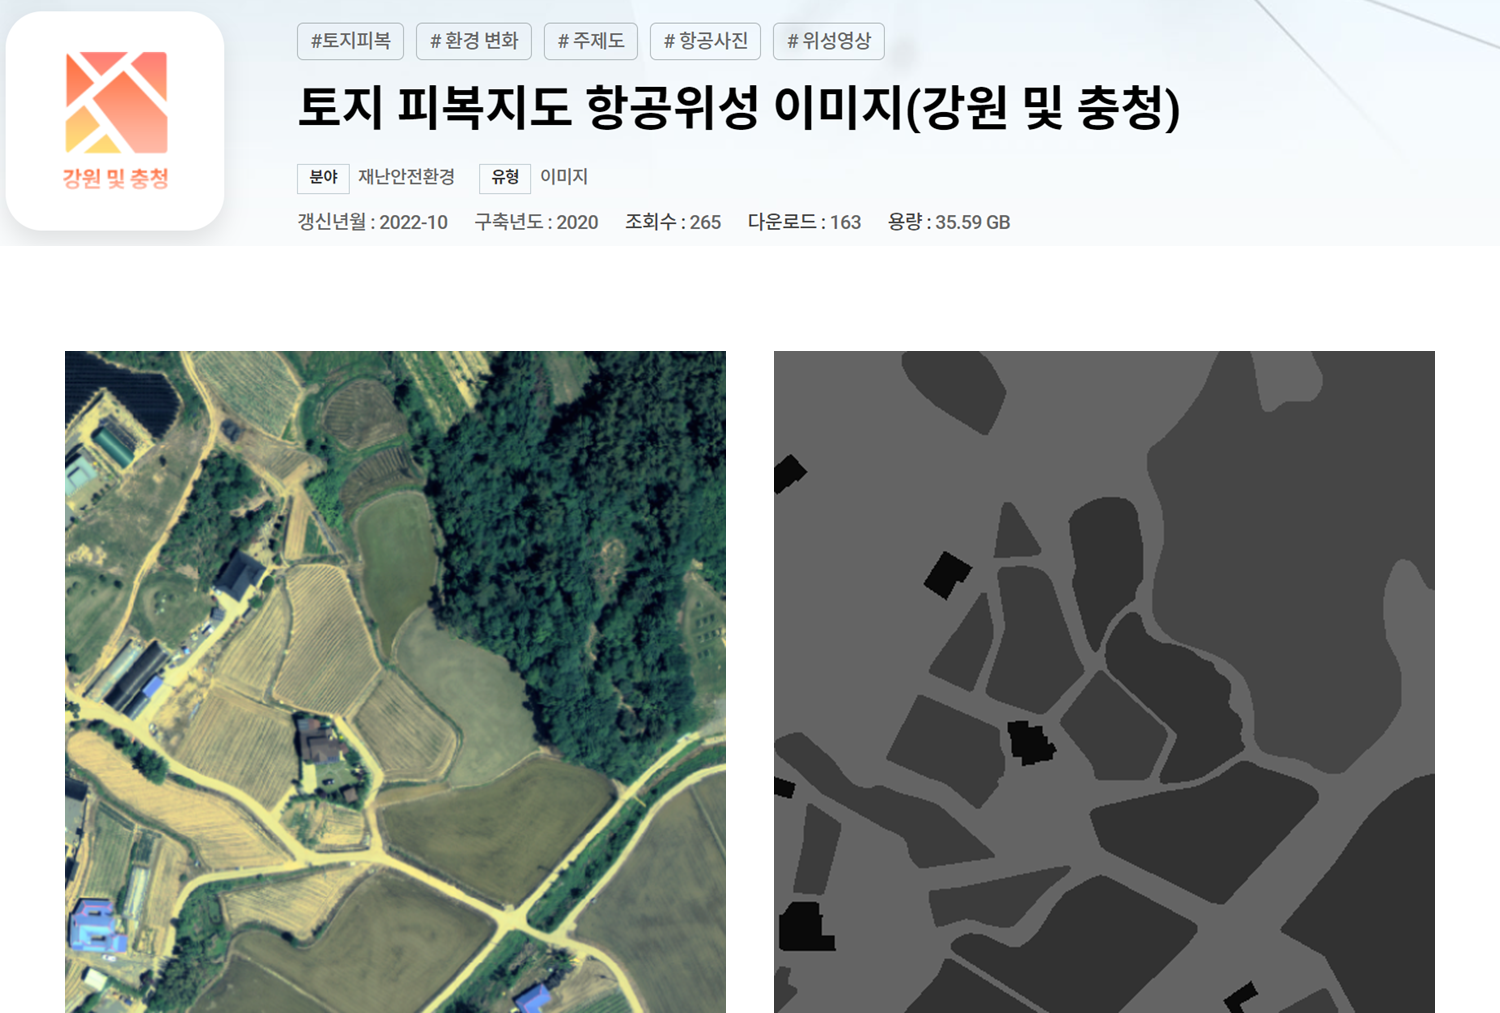

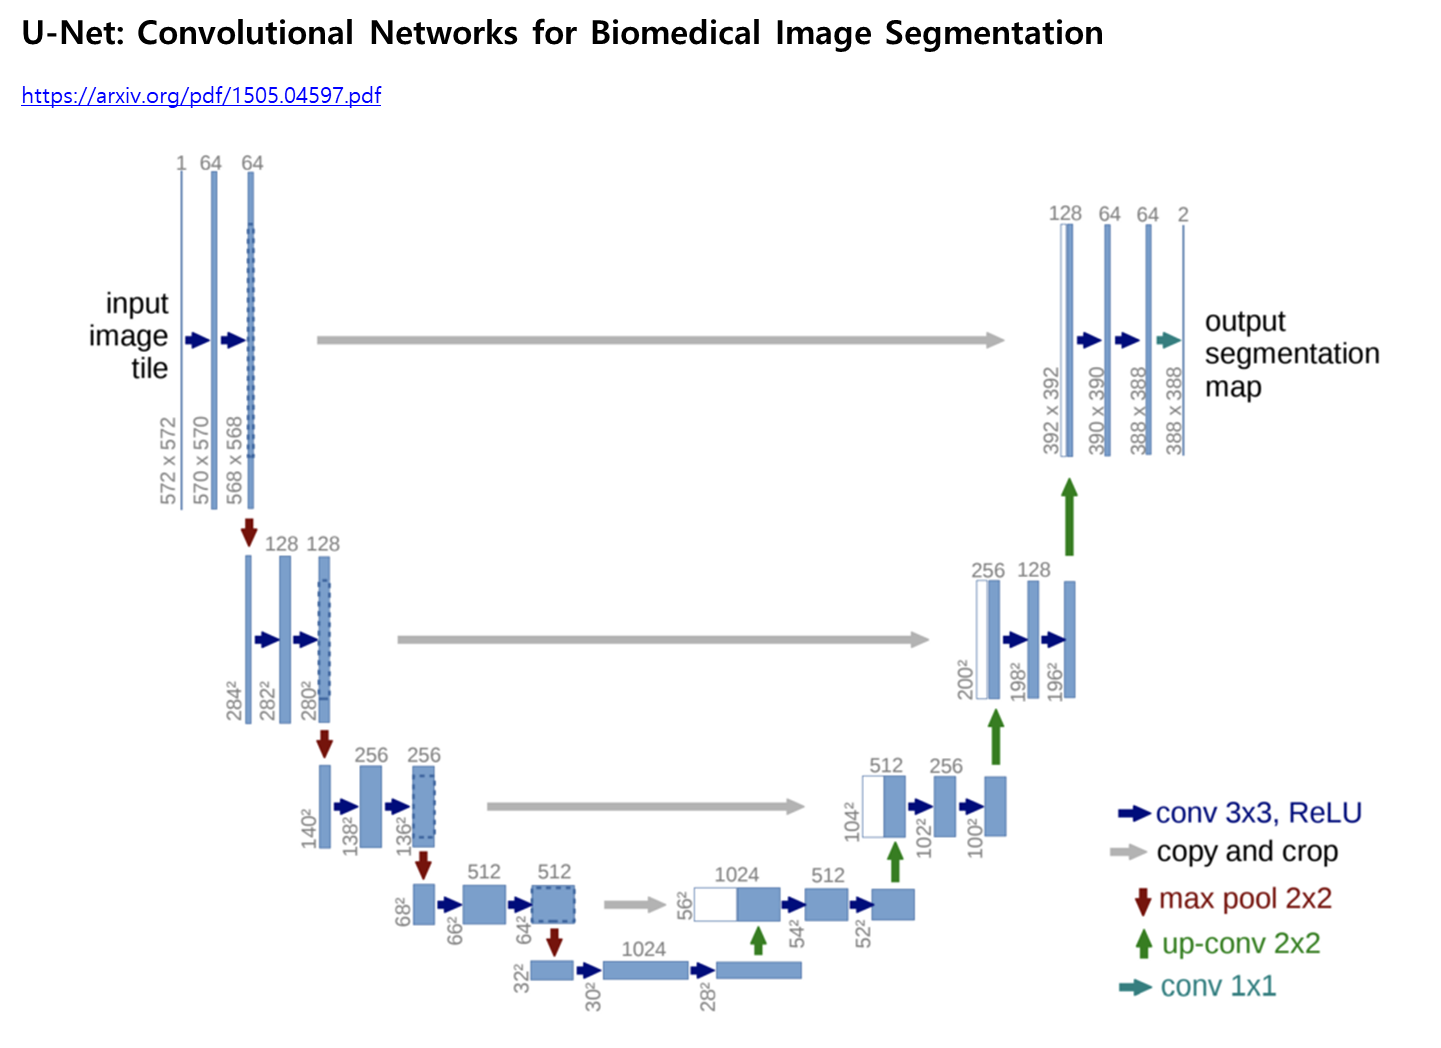

In [ ]:
#raster image file 읽기 위한 라이브러리
!pip install imagecodecs
!pip install tifffile

In [ ]:

import os
import sys
import random
import warnings
from glob import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.models import load_model

import tensorflow as tf

from PIL import Image

import matplotlib.pyplot as plt


#from keras_unet.models import vanilla_unet


import tifffile as tiff
import ipywidgets



In [ ]:
!wget "https://hycms.hanyang.ac.kr/index.php?module=xn_media_content2013&act=dispXn_media_content2013DownloadContent&content_id=67147a2b10139" -O "data.zip"
!unzip  -O cp949 "data.zip" -d "data"

In [ ]:

def imgshow(img, dpi = 80):
    figsize = 500/float(dpi), 500/float(dpi)
    fig = plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show()

In [ ]:

원천= glob('data/unet/img/*')


training_x = []
for img in 원천[:]:
    img = Image.open(img)
    img = np.array(img)
    training_x.append(img)
training_x = np.array(training_x)

원천[0]

In [ ]:
print(training_x.shape)

imgshow(training_x[0,:,:,:])

In [ ]:
검증 = glob('data/unet/val/*')


val_x = []
for img in 검증[:]:
    img = Image.open(img)
    img = np.array(img)
    val_x.append(img)
val_x = np.array(val_x)

plt.imshow(val_x[0,:,:])

In [ ]:
# 라벨 = glob('data/unet/val/*')


training_y = []
for tif in 원천[:]:
    tif = 'data/unet/tif/' + tif.split('/')[3].split('.')[0] + '_FGT.tif'
    tif = tiff.imread(tif)
    tif = np.array(tif)
    training_y.append(tif)

training_y = np.array(training_y)
training_y = training_y[:, :, :, np.newaxis]


In [ ]:
def display_data(idx=0):
  plt.figure(figsize=(15, 15))

  display_list = [training_x[idx, :, : ,:], training_y[idx, :, : ,0]]
  title = ['Input Image', 'output Tiff']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')


In [ ]:
#위젯을 이용하여  검증 결과 출력하기
ipywidgets.interact(display_data, idx=(0, training_x.shape[0], 1) )

#TIFF 이미지 값 의미
*   10	건물
*   20	주차장
*   30	도로
*   40	가로수
* 50	논
* 60	밭
* 70	산림
* 80	나지
* 100	비대상지

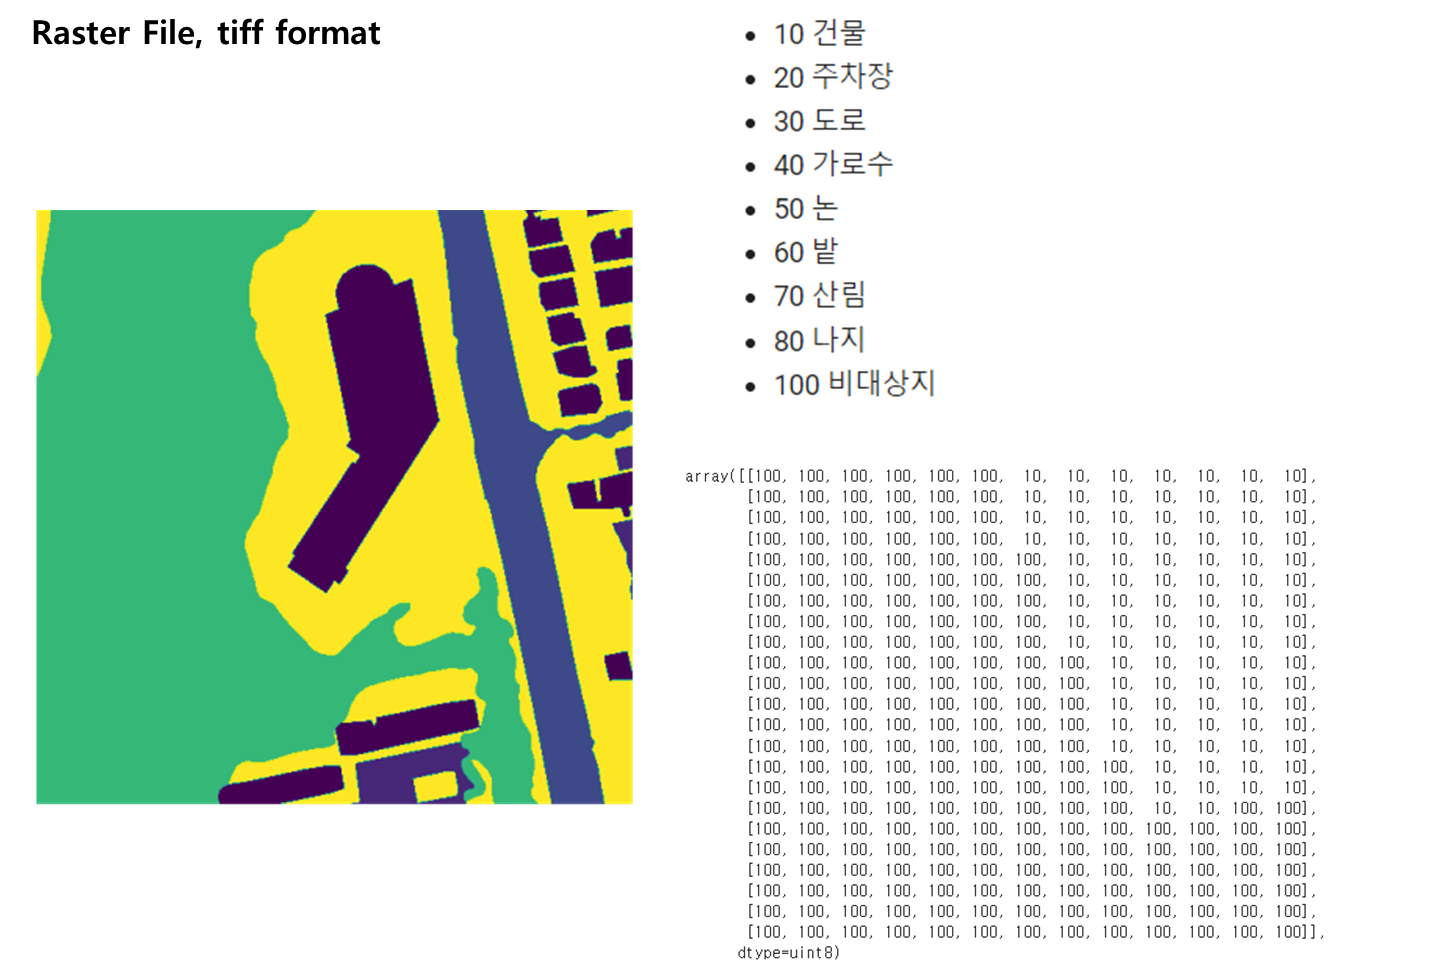

In [ ]:
print(training_y.shape)
imgshow(training_y[0,:,:,0])


In [ ]:
training_y[0,:,:,0]

In [ ]:
#건물만 제외하고 삭제
if np.max(training_y) > 1 :
  training_y[np.where(training_y != 10)] = 0
  training_y[np.where(training_y > 0)] = 1

In [ ]:
plt.imshow(training_y[0,:,:,0] , vmin=0, vmax=1, cmap='RdBu')
plt.show()

In [ ]:
inputs = Input((512, 512, 3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()


In [ ]:

earlystopper = EarlyStopping(patience=20, verbose=1)
checkpointer = ModelCheckpoint('model-unet.keras', verbose=1, save_best_only=True)
results = model.fit(training_x, training_y, validation_split=0.1, batch_size=16, epochs=100,
                    callbacks=[ checkpointer]) #earlystopper,
# model.save('unet.h5')

In [ ]:

def display_result(idx=0):
  predy = model.predict(training_x[idx:idx+1,:,:,:])

  predy[np.where(predy < 0.5)] = 0
  predy[np.where(predy >= 0.5)] = 1


  plt.figure(figsize=(15, 15))

  display_list = [training_x[idx, :, : ,:], predy[0, :, : ,0], training_y[idx, :, : ,0]]
  title = ['Input Image', 'Predicted Image', 'Ground Truth']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i])
    plt.axis('off')


In [ ]:
#위젯을 이용하여  검증 결과 출력하기
ipywidgets.interact(display_result, idx=(0, training_x.shape[0], 1) )

In [ ]:

def display_validation(idx=0, type =0):
  predy = model.predict(val_x[idx:idx+1,:,:,:])

  predy[np.where(predy < 0.5)] = 0
  predy[np.where(predy >= 0.5)] = 1


  plt.figure(figsize=(9, 9))

  if type == 0 :
    display_list = [val_x[idx, :, : ,:], predy[0, :, : ,0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.title(title[i])
      # Getting the pixel values in the [0, 1] range to plot.
      plt.imshow(display_list[i])
      plt.axis('off')
  else:
    ret = val_x[idx,:,:,:].copy()

    plt.figure(figsize=(9, 9))

    ret[ :, : ,0] = ret[ :, : ,0] + predy[0, :, : ,0] * 100
    ret[ :, : ,1] = ret[ :, : ,1] - predy[0, :, : ,0] * 100
    ret[ :, : ,2] = ret[ :, : ,2] - predy[0, :, : ,0] * 100

    ret[np.where(ret > 255)] = 255
    ret[np.where(ret < 0 )] = 0

    plt.imshow(ret)
    plt.axis('off')


In [ ]:
#위젯을 이용하여  검증 결과 출력하기
ipywidgets.interact(display_validation, idx=(0, val_x.shape[0], 1), type=(0,1,1))


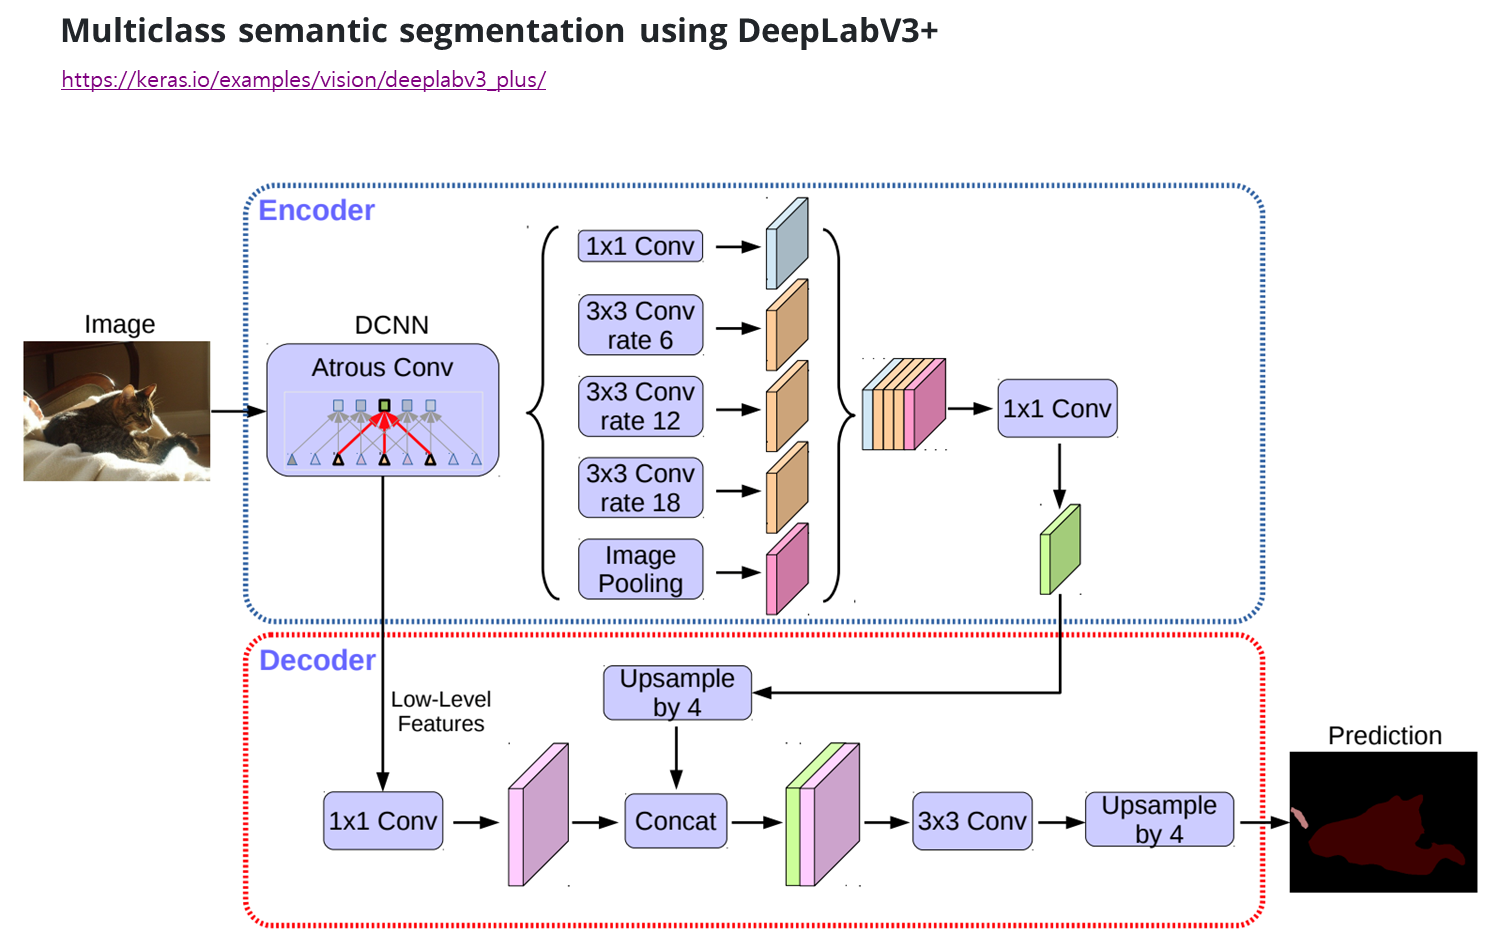

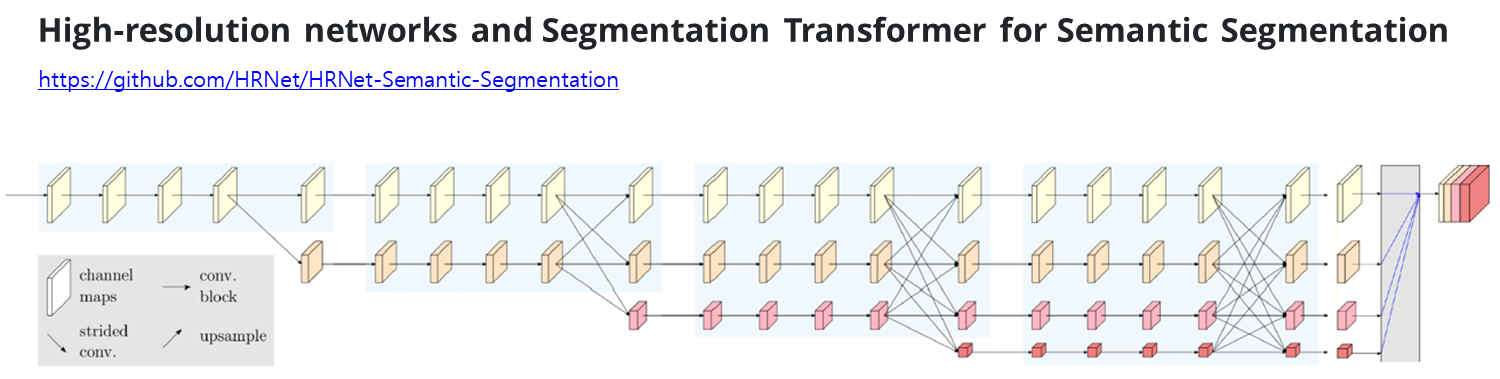

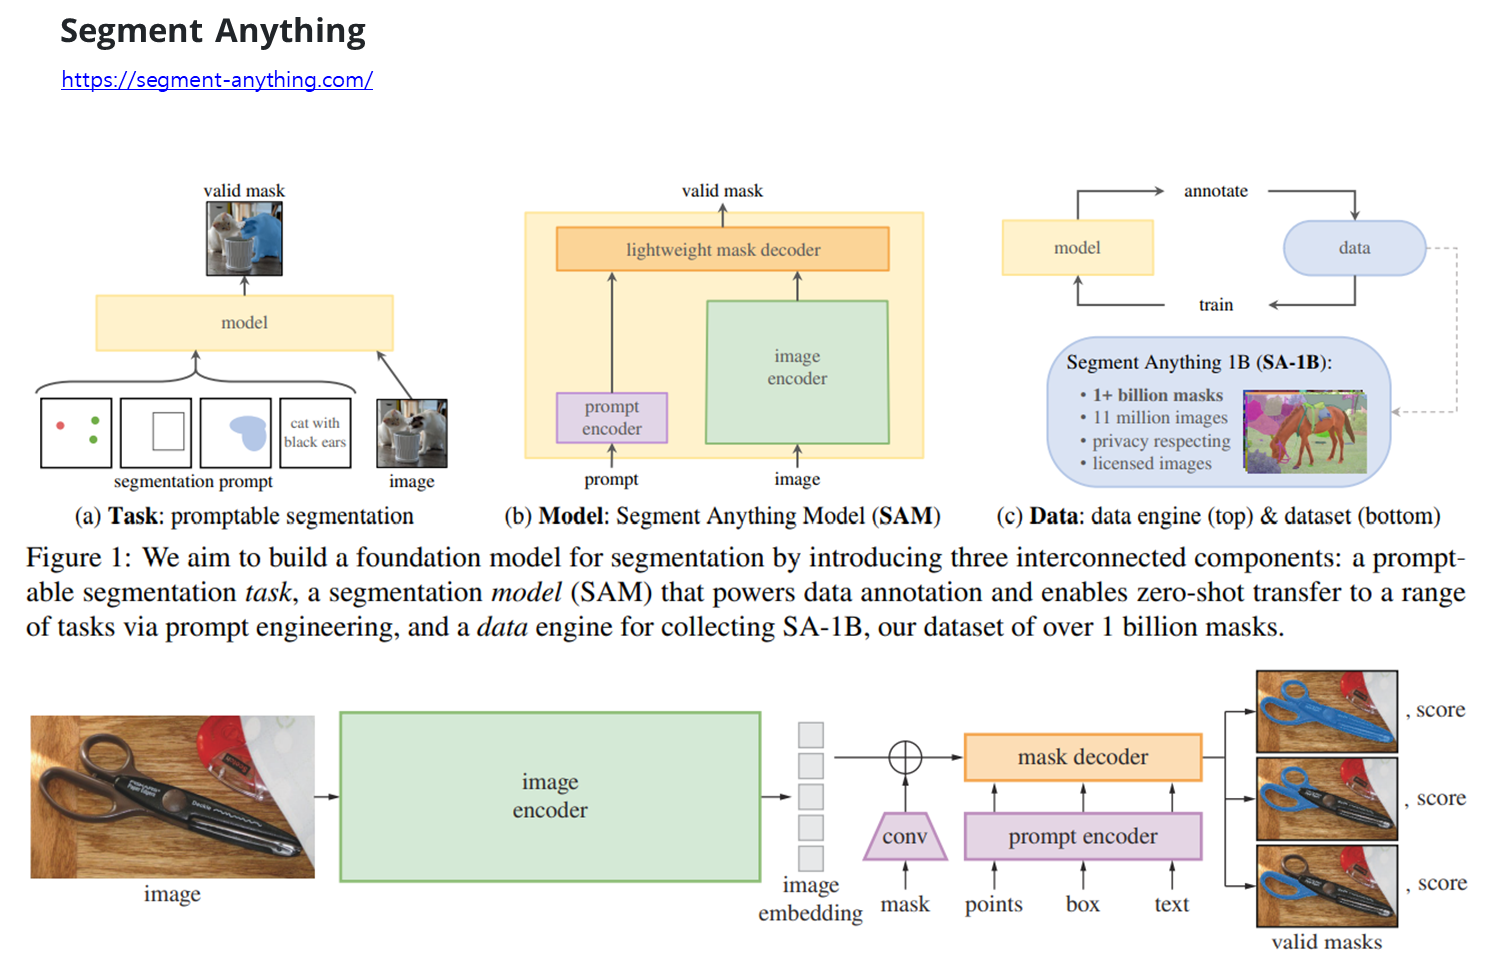

https://segment-anything.com/demo